# Summary
* This notebook analyzes the text of the smell descriptions in df_stinky (dataframe merging data from SmellMyCity and SeeClickFix) and produces visualizations based on this text analysis.
* These visualizations can be updated if new data is added to df_stinky. (See instructions below.)
* Attempts at building a classifier are included at the end of this notebook. A discussion of each attempt's method and results is included in text cells above the code for each attempt, in the hope this will be helpful for building a better classifier in the future. The goal is to tag each report by smell type or, at the very least, as 'oil-related' or 'not oil-related'.

# Instructions
* This notebook can be run from beginning to end (Runtime --> Run all)
* Visualizations can be downloaded by right-clicking on each image
* If new data is added to df_stinky, running this notebook from beginning to end will update all visualizations included below.

In [7]:
# load df_stinky from csv files saved to group github
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

url_stinky = 'https://raw.githubusercontent.com/ds5110/stinky/master/smell_data/smell_intermediary_files/df_stinky.csv'
df_stinky = pd.read_csv(url_stinky)

# Word cloud of smell descriptions
* Build word cloud of smell descriptions from df_stinky
* Larger font size means higher frequency
* Uses wordcloud module built by Andreas Mueller. Code available [here](https://github.com/amueller/word_cloud).
* Mueller uses scikit-learn's [CountVectorizer](https://scikit-learn.org/dev/modules/feature_extraction.html#common-vectorizer-usage) and extracts the 200 most frequent words, after filtering for 'stopwords' (common English words). More information on his approach available in his [blog post](https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html).

In [8]:
# send smell descriptions to list
smell_txt = np.array(df_stinky['smell description'])

# there are NaN values in smell_txt, due to missing smell descriptions in df_stinky
print('There are {} NaN values in df_stinky smell descriptions'.format(df_stinky['smell description'].isna().sum()))

There are 599 NaN values in df_stinky smell descriptions


In [9]:
# convert NaN to 'None' (wordcloud code will not accept NaN values)
smell_txt = np.array(['None' if x is np.nan else x for x in smell_txt])

In [10]:
# write smell_txt to txt file (required input for wordcloud)
with open("output.txt", "w") as txt_file:
  for item in smell_txt:
    if item != "None":
      txt_file.write("".join(item) + "\n")

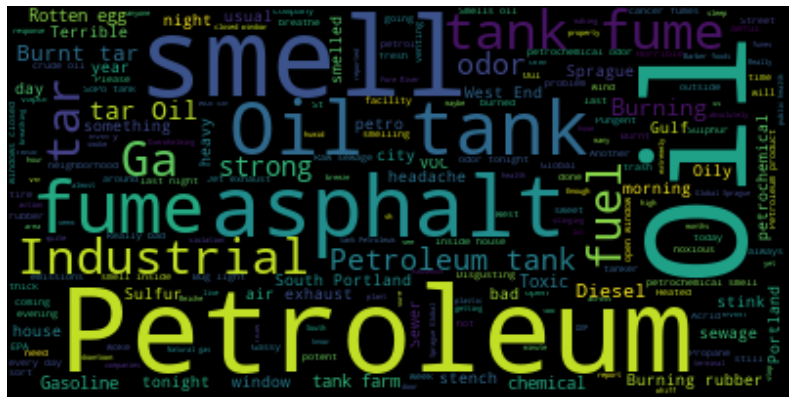

In [11]:
# build word cloud

# code in this cell and cell below taken from here: https://github.com/amueller/word_cloud/blob/master/examples/simple.py

import os
from os import path
from wordcloud import WordCloud

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, '/content/output.txt')).read()

wordcloud = WordCloud().generate(text)

# display the word cloud (the matplotlib way)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

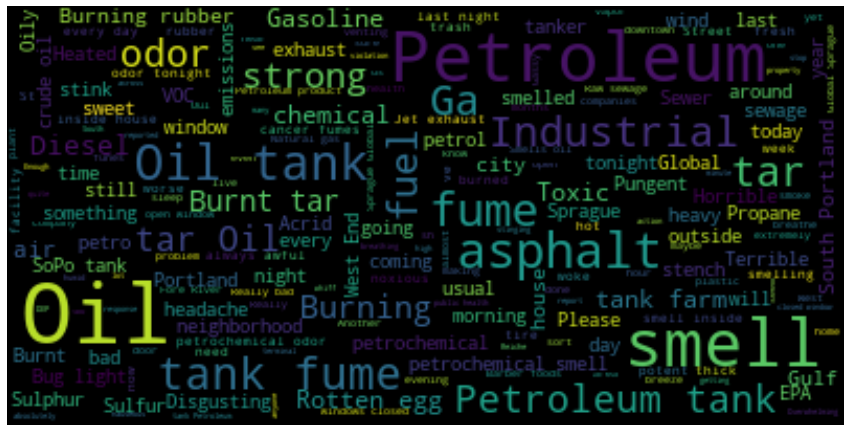

In [12]:
# lower max_font_size to show more words and increase figure size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

# Histogram showing distribution of odor complaints by time of day

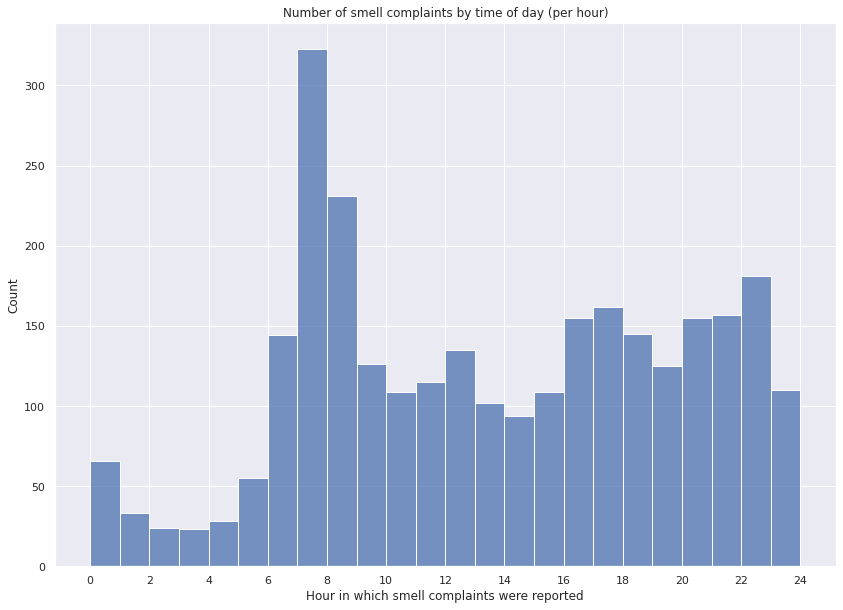

In [13]:
# get hour smell complaints were reported from df_stinky
time = df_stinky['Hour']

# set bins
hours = np.array(range(0,25))

# create subplots and change figure size
fig, ax = plt.subplots()

# set title
ax.set_title('Number of smell complaints by time of day (per hour)')

# change x-axis label and add ticks every 2 hours
ax.set_xlabel('Hour in which smell complaints were reported')
ax.set_xticks(list(range(0, 25, 2)))

# set figure size and plot histogram
sns.histplot(x=time, stat='count', bins=hours)
sns.set(rc={'figure.figsize':(14, 10)});

# Build histogram of most frequent words in smell descriptions
* Using sklearn's [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* There are 1,394 unique words in the smell descriptions.

In [14]:
# (code from DS5110 lecture notes, 11-NLP)

from sklearn.feature_extraction.text import CountVectorizer

# replace NaN in smell descriptions with empty value
df_stinky['smell description'] = df_stinky['smell description'].fillna('')

# create sparse matrix listing number of times each word appears in each row of smell descriptions
count = CountVectorizer()
sparse_matrix = count.fit_transform(df_stinky['smell description'].fillna(''))

# convert to array
a = sparse_matrix.toarray().sum(axis=0)
print(sparse_matrix.shape)
print(a.shape)

# get words
feature_names = count.get_feature_names()

# .argsort() -- returns indices to sort the array
sorted_indices = np.argsort(-a)
sorted_count = [a[i] for i in sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]
print('Number of features:', len(sorted_features))
print('First 10 counts:', sorted_count[:10])
print('First 10 features:', sorted_features[:10])
print('Last 10 counts:', sorted_count[-10:])
print('Last 10 features:', sorted_features[-10:])

(2907, 1394)
(1394,)
Number of features: 1394
First 10 counts: [795, 464, 290, 283, 275, 247, 223, 216, 175, 142]
First 10 features: ['oil', 'petroleum', 'fumes', 'smell', 'the', 'tar', 'tank', 'tanks', 'asphalt', 'and']
Last 10 counts: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Last 10 features: ['operations', 'distribution', 'order', 'ordinance', 'ordinances', 'organic', 'original', 'distress', 'dock', 'zone']


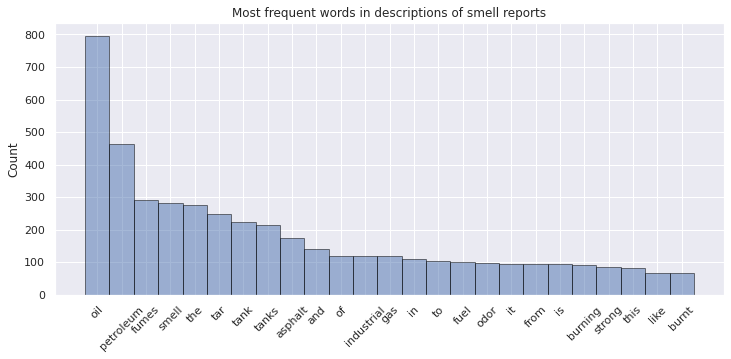

In [15]:
# build histogram
plt.subplots(1,1,figsize=(12,5))
plt.bar(sorted_features[:25], sorted_count[:25], 
        width=1, alpha=.5, edgecolor='black')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Most frequent words in descriptions of smell reports');

# Build histogram of 'most important' words in smell descriptions
* 'Most important' means a term that occurs frequently in an individual smell description but is not used too frequently across the entire corpus of smell descriptions.
* This uses td-idf (Term Frequency - Inverse Document Frequency) and [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
* There are 1220 most important terms when number of words = 1 and 2753 most important terms when number of words = 2.

In [16]:
# function for building tfidf vectorizer (code from DS5110 lecture notes, 11-NLP)
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf(num_words, documents):
  vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(num_words, num_words))

  # build sparse matrix using array of smell descriptions
  sparse_matrix = vectorizer.fit_transform(documents)

  feature_names = vectorizer.get_feature_names()

  # convert to ndarray, then sum terms
  a = sparse_matrix.toarray().sum(axis=0)

  # .argsort() -- returns indices to sort the array
  sorted_indices = np.argsort(-a)
  sorted_count = [a[i] for i in sorted_indices]
  sorted_features = [feature_names[i] for i in sorted_indices]
  print('Number of features:', len(sorted_features))
  print('First 50 features:', sorted_features[:50])

  return sorted_features, sorted_count

In [17]:
# function for plotting most frequent terms as a bar chart (code from 11-NLP)
def plot_tfidf(sorted_features, sorted_count):
  plt.subplots(1,1,figsize=(14,10))
  plt.bar(sorted_features[:25], sorted_count[:25], 
          width=1, alpha=.5, edgecolor='black')
  plt.xticks(rotation=45)
  plt.ylabel('Count');

Number of features: 1220
First 50 features: ['oil', 'petroleum', 'tar', 'fumes', 'tanks', 'tank', 'asphalt', 'smell', 'industrial', 'gas', 'fuel', 'burning', 'burnt', 'odor', 'strong', 'gasoline', 'diesel', 'like', 'rotten', 'smells', 'rubber', 'petrochemical', 'toxic', 'gulf', 'eggs', 'farm', 'exhaust', 'sewage', 'chemical', 'bad', 'house', 'sulfur', 'oily', 'sewer', 'propane', 'usual', 'portland', 'global', 'air', 'tonight', 'south', 'sprague', 'stink', 'sulphur', 'windows', 'terrible', 'jet', 'voc', 'sweet', 'morning']
Number of features: 2753
First 50 features: ['oil tanks', 'tank fumes', 'petroleum tank', 'burnt tar', 'oil smell', 'oil fumes', 'oil tar', 'petroleum smell', 'rotten eggs', 'oil asphalt', 'burning rubber', 'tank farm', 'fuel oil', 'oil tank', 'smells like', 'oil fuel', 'petroleum fumes', 'tar oil', 'petroleum asphalt', 'toxic oil', 'gas oil', 'petroleum tar', 'industrial petroleum', 'oil gas', 'petroleum odor', 'strong oil', 'oil diesel', 'fuel smell', 'strong petrol

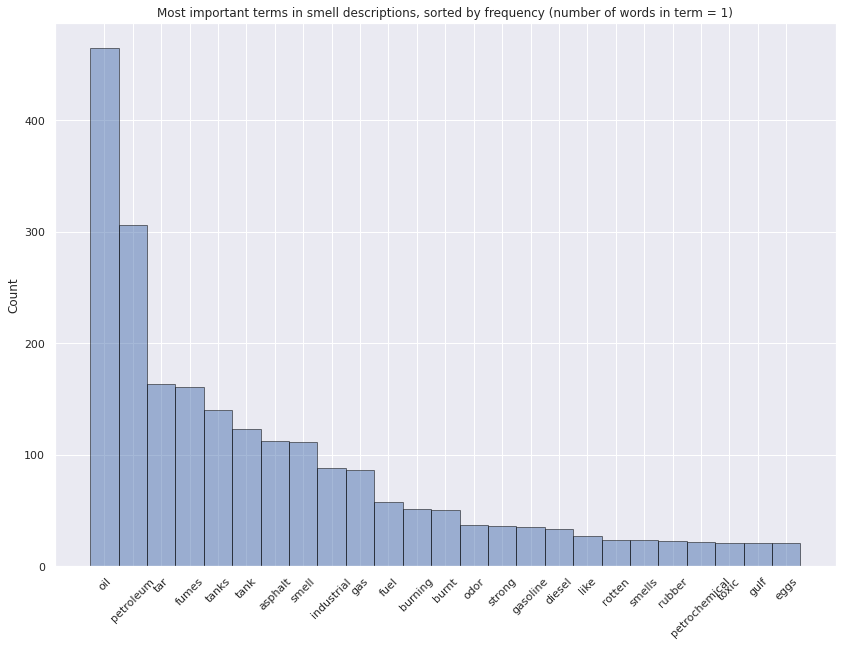

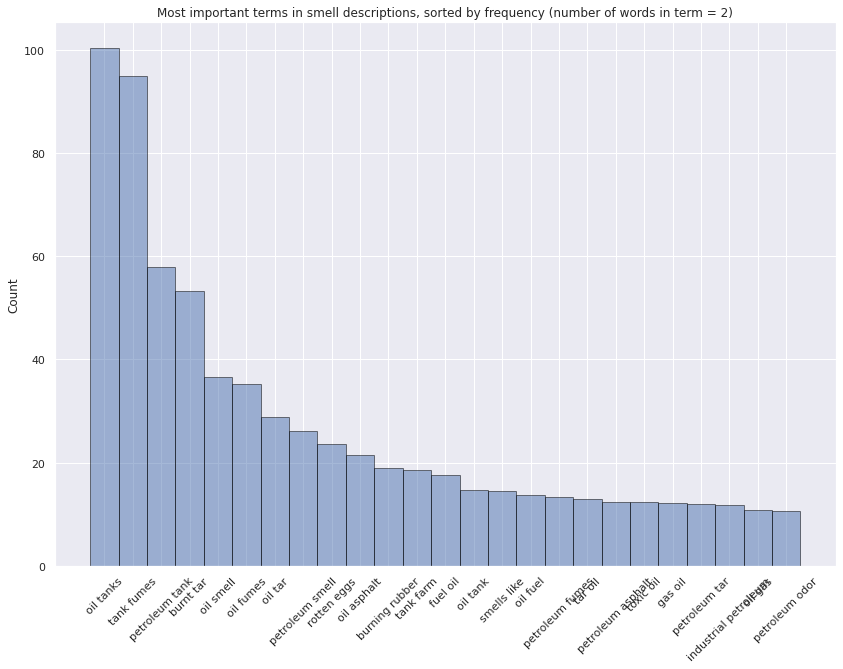

In [18]:
# plot top terms with number of words = 1 and number of words = 2
for i in range(1, 3):
  num_words = i
  sorted_features, sorted_count = build_tfidf(num_words, df_stinky['smell description'])
  plot_tfidf(sorted_features, sorted_count)
  plt.title('Most important terms in smell descriptions, sorted by frequency (number of words in term = {})'.format(i))

# Build histogram of 'most important' words in smell descriptions after applying a stemming algorithm 
* Uses Porter-Stemmer algorithm
* The results do not change much: 1204 terms when number of words = 1.

In [19]:
# get unique terms in 'smell descriptions'
smell_descr_split_row = df_stinky['smell description'].str.split(' ').values
smell_descr_split_row

array([list(['Petroleum', 'smell', 'coming', 'from', 'south', 'portland']),
       list(['usual', 'petroleum']), list(['usual', 'petroleum']), ...,
       list(['Petroleum', 'smell', 'most', 'nites', 'at', '2am!!']),
       list(['Tar']),
       list(['Tar', 'and', 'oil,', 'burning', 'rubber', ''])],
      dtype=object)

In [20]:
# get stopwords, or common English words to ignore
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

stop = stopwords.words('english')

porter = PorterStemmer()

stemmed_descr = []
for row in smell_descr_split_row:
  # stem each row and append to stemmed_descr
  stemmed_descr.append(' '.join([porter.stem(word) for word in row if word not in stop]))

# first ten smell descriptions, after words have been stemmed
stemmed_descr[:10]

['petroleum smell come south portland',
 'usual petroleum',
 'usual petroleum',
 'worst yet',
 'usual petroleum stink. cushman reich play field\r\n',
 'india commercial. across sopo tanks. veri strong petroleum odor. I lung diseas irritating.\r\ntim get litigated\r\n',
 'usual stink',
 'usual. reich pool well',
 ' usual stink bay. time updat dep council. absolut excus lack action plan',
 'petroleum odor strong cushman/clark/ reich pool park lot . ']

Number of features: 1204
First 50 features: ['oil', 'petroleum', 'tank', 'tar', 'fume', 'smell', 'asphalt', 'industri', 'ga', 'fuel', 'burn', 'burnt', 'odor', 'strong', 'diesel', 'gasolin', 'like', 'rotten', 'rubber', 'toxic', 'gulf', 'egg', 'farm', 'industrial', 'chemic', 'exhaust', 'fumes', 'petrochem', 'sewag', 'gas', 'bad', 'sulfur', 'sewer', 'tanks', 'propan', 'stink', 'oili', 'portland', 'usual', 'air', 'sulphur', 'window', 'tonight', 'south', 'veri', 'hous', 'jet', 'voc', 'heat', 'global']


Text(0.5, 1.0, 'Most important terms, after stemming, in smell descriptions (number of words in term = 1')

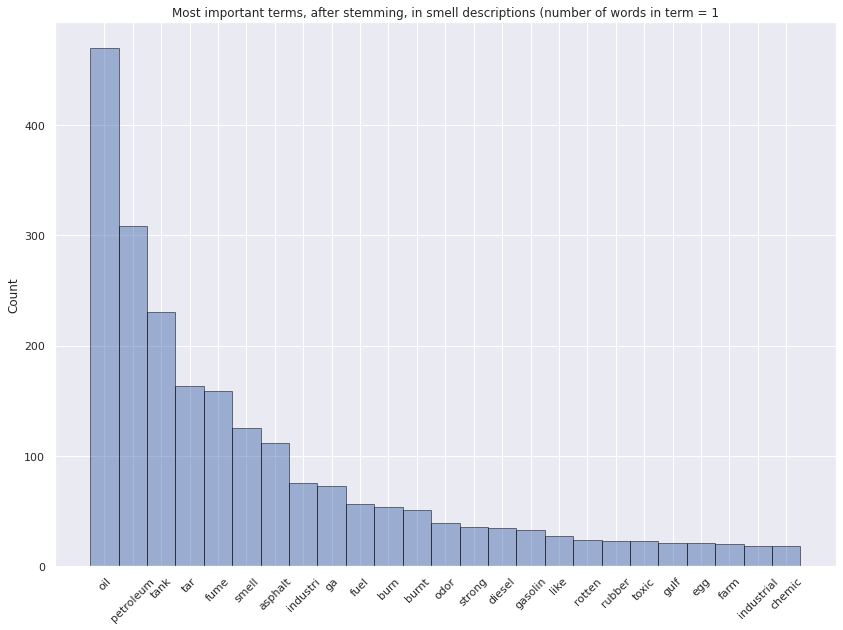

In [22]:
# build histogram of most important words, after stemming, when number of words = 1
sorted_features, sorted_count = build_tfidf(1, stemmed_descr)
plot_tfidf(sorted_features, sorted_count)
plt.ylabel('Count')
plt.title('Most important terms, after stemming, in smell descriptions (number of words in term = 1')

# Build classifier for smell descriptions from df_stinky
* This section includes attempts at building a classifier for the smell descriptions.
* The goal is to tag each smell description by smell type.
* A discussion of methods and results precedes each attempt.

## Approach 1: Get word per row with highest tf-idf score**
* Problem: top word per row is  not the correct tag. Example:
  * the first smell description in df_stinky: "Petroleum smell coming from south portland"
  * top term, according to tf-idf score: 'coming south'

In [23]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 3))

# build sparse matrix 
# rows are individual complaints
# columns are the tf-idf score for each word (~ word's importance across entire 'smell description' column)
sparse_matrix = vectorizer.fit_transform(df_stinky['smell description'])

# get vocabulary list (unique individual terms)
feature_names = vectorizer.get_feature_names()

# get index of term with max tf-idf score
topterm_index = sparse_matrix.argmax(axis=1)

# get top term per row
type(topterm_index)

numpy.matrix

In [24]:
# convert topterm_index to list (nested) and get top term per row
top_terms = []
for x in topterm_index.tolist():
  top_term = feature_names[x[0]]
  top_terms.append(top_term)

print(top_terms[:10])

['coming south', 'usual petroleum', 'usual petroleum', '00 near', 'cushman reiche playing', 'commercial sopo', 'usual stink', 'usual reiche', 'absolutely excuses', 'clark reiche']


# Approach 2: handpick tags using tf-idf top 10 and word cloud
* Problem: there is overlap between the different tags
  * Example: smell descriptions tagged as related to 'asphalt' also mention oil-related terms.

In [25]:
# handpicked list of tags
tags = {}
tags['asphalt'] = ['asphalt']
tags['sulphur'] = ['egg', 'rotten', 'sulphur']
tags['oil_related'] = ['oil', 'petroleum', 'petrol', 'petro', 'gas', 'diesel', 'fuel', 'industrial', 'chemical', 'rubber', 'exhaust']
tags['city'] = ['trash', 'truck', 'engine']

tags

{'asphalt': ['asphalt'],
 'city': ['trash', 'truck', 'engine'],
 'oil_related': ['oil',
  'petroleum',
  'petrol',
  'petro',
  'gas',
  'diesel',
  'fuel',
  'industrial',
  'chemical',
  'rubber',
  'exhaust'],
 'sulphur': ['egg', 'rotten', 'sulphur']}

In [26]:
# add column to df_stinky for 'smell type'
df_stinky.loc[:, 'smell_type'] = 'city'

# tag smell descriptions
def tag_smelltype(tags_dict, tag):
  df_stinky.loc[df_stinky['smell description'].str.contains('|'.join(tags_dict[str(tag)]), case=False), 'smell_type'] = tag

for key in tags:
   tag_smelltype(tags, key)

In [27]:
# rows tagged as related to 'asphalt' also mention oil-related terms
df_stinky.loc[df_stinky['smell description'].str.contains('asphalt')]

,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date,time,Day,Month,Year,Hour,Month_name,Date & time (hour rounded),geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments,smell_type
20,7539102.0,Web - Mobile,Odor,2020-03-11 19:27:00,2020-03-12 08:39:00,Archived,151 Vaughan St,Strong smell of gas or asphalt at 7:25pm.,https://crm.seeclickfix.com/#/organizations/61...,43.649476,-70.272871,City Council District 2,2020-03-11,19:27:00,11,3,2020,19,Mar,2020-03-11 19:00:00,"43.64947564,-70.27287096","151, Vaughan Street, West End, Portland, Cumbe...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
107,8042604.0,iPhone,Odor,2020-06-20 17:15:00,2020-06-23 11:07:00,Archived,198 Danforth St,Fuel/asphalt smell - stinging eyes,https://crm.seeclickfix.com/#/organizations/61...,43.648417,-70.263643,City Council District 2,2020-06-20,17:15:00,20,6,2020,17,Jun,2020-06-20 17:00:00,"43.64841724,-70.26364252","200, Danforth Street, Arts District, Portland,...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
117,8051608.0,Portal,Odor,2020-06-22 21:57:00,2020-06-23 11:07:00,Archived,Spring St & Vaughan St,"Toxic smelling odor, smelled like burning rubb...",https://crm.seeclickfix.com/#/organizations/61...,43.645656,-70.272717,City Council District 2,2020-06-22,21:57:00,22,6,2020,21,Jun,2020-06-22 21:00:00,"43.64565585,-70.27271748","398, Spring Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
118,8051615.0,Portal,Odor,2020-06-22 22:00:00,2020-06-23 11:07:00,Archived,116 Pine St,"Toxic smelling odor, smells like asphalt and b...",https://crm.seeclickfix.com/#/organizations/61...,43.649433,-70.270434,City Council District 2,2020-06-22,22:00:00,22,6,2020,22,Jun,2020-06-22 22:00:00,"43.649433,-70.270434","116, Pine Street, West End, Portland, Cumberla...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
123,8051945.0,iPhone,Odor,2020-06-23 01:07:00,2020-06-23 11:07:00,Archived,High And York,Odor from the tanks. Smells like asphalt.,https://crm.seeclickfix.com/#/organizations/61...,43.651187,-70.258127,City Council District 2,2020-06-23,01:07:00,23,6,2020,1,Jun,2020-06-23 01:00:00,"43.651186700000004,-70.2581265","101, York Street, Old Port, Portland, Cumberla...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,asphalt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petroleum/ asphalt,NaN,43.628800,-70.270000,NaN,2021-06-16,17:29:24,16,6,2021,17,Jun,2021-06-16 17:00:00,NaN,NaN,South Portland,1.623879e+09,2021-06-16 17:29:24,4.0,4106.0,NaN,NaN,oil_related
2753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petroleum / asphalt,NaN,43.629400,-70.268100,NaN,2021-06-17,14:13:35,17,6,2021,14,Jun,2021-06-17 14:00:00,NaN,NaN,South Portland,1.623954e+09,2021-06-17 14:13:35,4.0,4106.0,NaN,NaN,oil_related
2754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Industrial, asphalt",NaN,43.651100,-70.274200,NaN,2021-06-17,19:46:21,17,6,2021,19,Jun,2021-06-17 19:00:00,NaN,NaN,Portland,1.623974e+09,2021-06-17 19:46:21,3.0,4102.0,NaN,NaN,oil_related
2756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Strong industrial odor, asphalt",NaN,43.650300,-70.273800,NaN,2021-06-17,22:57:47,17,6,2021,22,Jun,2021-06-17 22:00:00,NaN,NaN,Portland,1.623985e+09,2021-06-17 22:57:47,4.0,4102.0,NaN,NaN,oil_related


# Approach 3: Handpick list but use two tags only (oil and not oil)
* Problem: not all smell descriptions use keywords that may indicate a smell type
  * Example: see smell descriptions used by user at 25 Cushman St. The descriptions that do not mention oil seem to be about oil nevertheless.

In [28]:
oil_keywords = ['oil', 'petroleum', 'petrol', 'petro', 'gas', 'gasoline', 'diesel', 'fuel', 'industrial', 'chemical', 'rubber', 'exhaust', 'asphalt', 'tank', 'tanks', 'tar']

In [29]:
# add column to df_stinky for 'smell type'
df_stinky.loc[:, 'smell_type'] = 'other'

# tag smell descriptions
df_stinky.loc[df_stinky['smell description'].str.contains('|'.join(oil_keywords), case=False), 'smell_type'] = 'oil_related'

df_stinky.head()

,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date,time,Day,Month,Year,Hour,Month_name,Date & time (hour rounded),geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments,smell_type
0,7181157.0,iPhone,Odor,2020-01-07 08:26:00,2020-01-07 09:20:00,Archived,315 Spring Street,Petroleum smell coming from south portland,https://crm.seeclickfix.com/#/organizations/61...,43.647740,-70.269455,City Council District 2,2020-01-07,08:26:00,7,1,2020,8,Jan,2020-01-07 08:00:00,"43.64774,-70.26945450000001","315, Spring Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
1,7181402.0,Android,Odor,2020-01-07 09:11:00,2020-01-07 09:20:00,Archived,25 Cushman St,usual petroleum,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-07,09:11:00,7,1,2020,9,Jan,2020-01-07 09:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
2,7192000.0,Android,Odor,2020-01-09 07:14:00,2020-01-09 08:45:00,Archived,25 Cushman St,usual petroleum,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-09,07:14:00,9,1,2020,7,Jan,2020-01-09 07:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
3,7206428.0,Android,Odor,2020-01-13 08:22:00,2020-01-13 09:09:00,Archived,25 Cushman St,worst yet,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-13,08:22:00,13,1,2020,8,Jan,2020-01-13 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
4,7210067.0,Android,Odor,2020-01-14 08:24:00,2020-01-14 14:50:00,Archived,25 Cushman St,usual petroleum stink. Cushman and Reiche play...,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-14,08:24:00,14,1,2020,8,Jan,2020-01-14 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related


In [30]:
df_stinky.loc[df_stinky['smell_type']=='oil_related'].count()

Id                             216
Report Source                  216
Category                       216
Created at local               216
Closed at local                214
Status                         216
Address                        216
smell description             2003
URL                            216
Latitude                      2003
Longitude                     2003
Export tagged places           216
date                          2003
time                          2003
Day                           2003
Month                         2003
Year                          2003
Hour                          2003
Month_name                    2003
Date & time (hour rounded)    2003
geom                           216
address                        216
South Portland/Portland       2003
epoch time                    1787
date & time                   1787
smell value                   1787
zipcode                       1787
symptoms                       798
additional comments 

In [31]:
# most complaints by user at 25 Cushman St are tagged as other, though they seem oil-related
df_stinky.loc[df_stinky['Address']=='25 Cushman St']

,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date,time,Day,Month,Year,Hour,Month_name,Date & time (hour rounded),geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments,smell_type
1,7181402.0,Android,Odor,2020-01-07 09:11:00,2020-01-07 09:20:00,Archived,25 Cushman St,usual petroleum,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-07,09:11:00,7,1,2020,9,Jan,2020-01-07 09:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
2,7192000.0,Android,Odor,2020-01-09 07:14:00,2020-01-09 08:45:00,Archived,25 Cushman St,usual petroleum,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-09,07:14:00,9,1,2020,7,Jan,2020-01-09 07:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
3,7206428.0,Android,Odor,2020-01-13 08:22:00,2020-01-13 09:09:00,Archived,25 Cushman St,worst yet,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-13,08:22:00,13,1,2020,8,Jan,2020-01-13 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
4,7210067.0,Android,Odor,2020-01-14 08:24:00,2020-01-14 14:50:00,Archived,25 Cushman St,usual petroleum stink. Cushman and Reiche play...,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-14,08:24:00,14,1,2020,8,Jan,2020-01-14 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,oil_related
6,7221072.0,Android,Odor,2020-01-15 16:05:00,2020-01-21 09:55:00,Archived,25 Cushman St,usual stink,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-15,16:05:00,15,1,2020,16,Jan,2020-01-15 16:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
7,7224338.0,Android,Odor,2020-01-16 08:01:00,2020-01-21 09:55:00,Archived,25 Cushman St,as usual. by Reiche pool as well,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-16,08:01:00,16,1,2020,8,Jan,2020-01-16 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
8,7242521.0,Android,Odor,2020-01-21 07:25:00,2020-01-21 09:55:00,Archived,25 Cushman St,Usual stink from Bay. Time for an update from...,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-21,07:25:00,21,1,2020,7,Jan,2020-01-21 07:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
10,7418849.0,Android,Odor,2020-02-13 08:30:00,2020-02-13 08:39:00,Archived,25 Cushman St,again,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-02-13,08:30:00,13,2,2020,8,Feb,2020-02-13 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
16,7514195.0,Android,Odor,2020-03-06 07:29:00,2020-03-06 08:43:00,Archived,25 Cushman St,again\r\nLewis Cushman Reiche at least,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-03-06,07:29:00,6,3,2020,7,Mar,2020-03-06 07:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
26,7562568.0,Android,Odor,2020-03-18 07:58:00,2020-03-18 08:26:00,Archived,25 Cushman St,usual source. stinks,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-03-18,07:58:00,18,3,2

In [32]:
# this occurs with many other rows tagged as 'other'
df_stinky.loc[df_stinky['smell_type']=='other']

,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date,time,Day,Month,Year,Hour,Month_name,Date & time (hour rounded),geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments,smell_type
3,7206428.0,Android,Odor,2020-01-13 08:22:00,2020-01-13 09:09:00,Archived,25 Cushman St,worst yet,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-13,08:22:00,13,1,2020,8,Jan,2020-01-13 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
6,7221072.0,Android,Odor,2020-01-15 16:05:00,2020-01-21 09:55:00,Archived,25 Cushman St,usual stink,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-15,16:05:00,15,1,2020,16,Jan,2020-01-15 16:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
7,7224338.0,Android,Odor,2020-01-16 08:01:00,2020-01-21 09:55:00,Archived,25 Cushman St,as usual. by Reiche pool as well,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-16,08:01:00,16,1,2020,8,Jan,2020-01-16 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
8,7242521.0,Android,Odor,2020-01-21 07:25:00,2020-01-21 09:55:00,Archived,25 Cushman St,Usual stink from Bay. Time for an update from...,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-21,07:25:00,21,1,2020,7,Jan,2020-01-21 07:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
10,7418849.0,Android,Odor,2020-02-13 08:30:00,2020-02-13 08:39:00,Archived,25 Cushman St,again,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-02-13,08:30:00,13,2,2020,8,Feb,2020-02-13 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,43.628400,-70.279700,NaN,2021-07-21,20:09:08,21,7,2021,20,Jul,2021-07-21 20:00:00,NaN,NaN,South Portland,1.626913e+09,2021-07-21 20:09:08,5.0,4106.0,NaN,NaN,other
2896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,43.621300,-70.278000,NaN,2021-07-21,22:42:58,21,7,2021,22,Jul,2021-07-21 22:00:00,NaN,NaN,South Portland,1.626922e+09,2021-07-21 22:42:58,4.0,4106.0,NaN,NaN,other
2897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Burnt brownies,NaN,43.643700,-70.258800,NaN,2021-07-22,05:52:59,22,7,2021,5,Jul,2021-07-22 05:00:00,NaN,NaN,South Portland,1.626948e+09,2021-07-22 05:52:59,5.0,4106.0,Nausea,NaN,other
2901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Putrid, rotting trash",NaN,43.633200,-70.264300,NaN,2021-07-22,18:51:59,22,7,2021,18,Jul,2021-07-22 18:00:00,NaN,NaN,South Portland,1.626994e+09,2021-07-22 18:51:59,5.0,4106.0,NaN,NaN,other


# Approach 4: Use [Huggingface](https://huggingface.co/facebook/bart-large-mnli)
* Problem: Too many rows are classified as 'petroleum' (79%)
  * This could be due to class labels being too similar
* [See results here](https://github.com/ds5110/stinky/blob/master/huggingface_results.ipynb): model takes ~30 minutes to run
* To update and download results of huggingface model: 
  * run two cells at the end of this section, currently commented out
  * upload updated huggingface_results.csv to [data folder](https://github.com/ds5110/stinky/tree/master/data)

In [33]:
# ONLY NEED TO RUN THIS CELL ONCE
!pip install transformers

     |████████████████████████████████| 2.6 MB 9.6 MB/s 
     |████████████████████████████████| 3.3 MB 24.1 MB/s 
     |████████████████████████████████| 895 kB 52.6 MB/s 
     |████████████████████████████████| 636 kB 70.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [34]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [35]:
# run classifier on one row
sequence_to_classify = df_stinky['smell description'][26]
candidate_labels = ['petroleum', 'trash', 'asphalt', 'urban']
test = classifier(sequence_to_classify, candidate_labels)

In [36]:
# inspect output
print(type(test))
print(test.keys())
print(test['scores'])
print(max(test['scores'])) # get max score
print(test['scores'].index(max(test['scores']))) # get index of max score
print(candidate_labels[test['scores'].index(max(test['scores']))]) # get label with max score
print(test['sequence'])

<class 'dict'>
dict_keys(['sequence', 'labels', 'scores'])
[0.8961744904518127, 0.05488656088709831, 0.032772503793239594, 0.016166463494300842]
0.8961744904518127
0
petroleum
usual source. stinks


In [37]:
# THIS CELL TAKES ~30 MINUTES TO RUN. Click on link above to see results in separate colab notebook.

# # apply classifier to entire df
# descr_array = np.array(df_stinky['smell description'])

# tags_array = []
# candidate_labels = ['petroleum', 'trash', 'asphalt', 'urban']

# i = 0
# for item in descr_array:
#   if item == '':
#     tags_array.append('no description provided')
#   else:
#     results = classifier(item, candidate_labels)
#     tags_array.append(candidate_labels[results['scores'].index(max(results['scores']))])
#   print('row {} processed'.format(i))
#   i += 1

# # add column to df_stinky for 'smell type'
# df_stinky.loc[:, 'smell_type'] = 'other'

# # replace values of 'smell_type' with tags_array
# df_stinky.loc[:, 'smell_type'] = tags_array
# df_stinky

In [38]:
# If run, this cell will download the updated huggingface_results.csv file

# # download df_stinky with smell_type tag added
# from google.colab import files
# df_stinky.to_csv('huggingface_results.csv', index=False) 
# files.download('huggingface_results.csv')